# 1. Bayesian calibration of Agent-Based Models with Variational Inference

In this tutorial we will show how to use the `blackbirds` package to calibrate an Agent-Based Model (ABM) using Variational Inference (VI). 
Let's start by providing a short introduction to VI. Given an ABM with parameters $\theta$ and observed data $y$, the goal of VI is to approximate the posterior distribution $p(\theta|y)$ with a simpler distribution $q(\theta)$ that is easier to work with. The optimal $q(\theta)$ is the one that minimizes the Kullback-Leibler divergence between $q(\theta)$ and $p(\theta|y)$.

It can be shown [[see ref]](https://arxiv.org/pdf/1904.02063.pdf) that given $n$ observations $x_{1:n}$, a prior distribution over the parameters $\theta$, a choice of variational family $q\in \mathcal Q$, and a loss function $\ell (\theta, x_i)$, the optimal $q_*(\theta)$ is given by

$$
q_*(\theta) = \argmin_{q\in \mathcal Q} \left\{ \mathbb E_{q(\theta)} \left[ \sum_{i=1}^n \ell (\theta, x_i) \right] + D(q||\pi) \right\}.
$$

In standard VI, the loss function is the negative log-likelihood of the data, $\ell (\theta, x_i) = -\log p(x_i|\theta)$, and distance measure $D$ is the Kullback-Leibler divergence. In the case of ABMs, the likelihood function is often intractable, and we need to resort to alternative loss functions such as the $L_2$ distance between the observed data and the ABM output. This method where the loss function is not the negative log-likelihood is called Generalized Variational Inference (GVI) [[see ref]](https://arxiv.org/pdf/1904.02063.pdf).

Luckily, we do not need to worry too much about the details of the optimization process, as the `blackbirds` package takes care of that for us. We only need to provide the ABM, the observed data, and the prior distribution over the parameters. Let's see how this works in practice.


In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from blackbirds.infer.vi import VI

[HAL-9093.local:40185] shmem: mmap: an error occurred while determining whether or not /var/folders/s5/jmvhvqns52q3ysypfjykg6y40000gr/T//ompi.HAL-9093.504/jf.0/4025876480/sm_segment.HAL-9093.504.eff60000.0 could be created.


# 2. Example: Calibration of a Random Walk

In the previous tutorial we implemented a differentiable Random Walk model. We now make a small modification by transforming the $\theta$ parameter to keep it in $[0, 1]$.

In [2]:
def random_walk(theta, n_timesteps, tau=0.5):
    theta = torch.sigmoid(theta) # to keep it phyiscal
    x = torch.tensor([0.0])
    for i in range(n_timesteps - 1):
        #logits = torch.hstack((theta, 1 - theta)).log()
        xi = torch.distributions.Bernoulli(theta).sample()
        xi = xi + (theta - theta.detach())
        #xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
        next_x = x[-1] + 2 * xi - 1
        x = torch.hstack((x, next_x))
    return x

Let's generate some synthetic data and use the `blackbirds` package to calibrate the model.

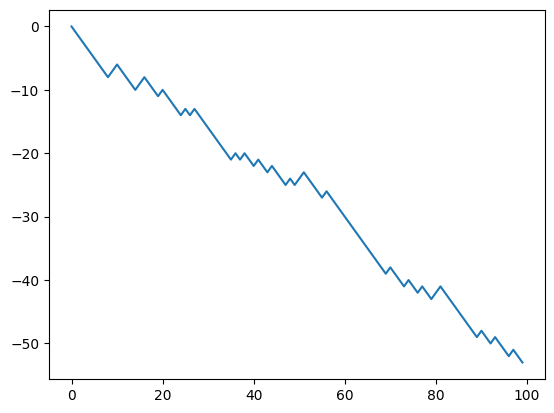

In [3]:
# Generate synthetic data
n_timesteps = 100
theta_true = torch.logit(torch.tensor([0.2]))
x_true = random_walk(theta_true, n_timesteps)
fig, ax = plt.subplots()
ax.plot(x_true, label='True')

We will use a Gaussian prior over $\theta$.

In [4]:
prior = torch.distributions.Normal(torch.logit(torch.tensor(0.5)), 1.0)

Now we need to choose a variational family for $q$. We will use a Normal distribution with learnable mean and variance.

In [5]:
class TrainableGaussian(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.zeros(1))
        self.sigma = torch.nn.Parameter(torch.ones(1))

    def sample(self, n):
        sigma = torch.clamp(self.sigma**2, 1e-2, 1e6)
        dist = torch.distributions.Normal(self.mu, sigma)
        theta = dist.rsample((n,))
        logprob = dist.log_prob(theta)
        return theta, logprob

Now we need to specify the loss $\ell(\theta, y)$. We will use the $L_2$ distance between the observed data and the model output:

In [6]:
def loss(theta, y):
    x = random_walk(theta, n_timesteps)
    return torch.nn.functional.mse_loss(x, y)

And we have all the ingredients!

In [7]:
q = TrainableGaussian()
optimizer = torch.optim.Adam(q.parameters(), lr=0.05)
vi = VI(loss,
    posterior_estimator=q,
    prior=prior,
    optimizer=optimizer,
    w = 100, # this is a relative weight between the loss and the KL term
    )
vi.run(x_true, n_epochs=100, max_epochs_without_improvement=50)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.43it/s, loss=134.58, reg=125.91, total=260.49, best=145.10, stall=23]


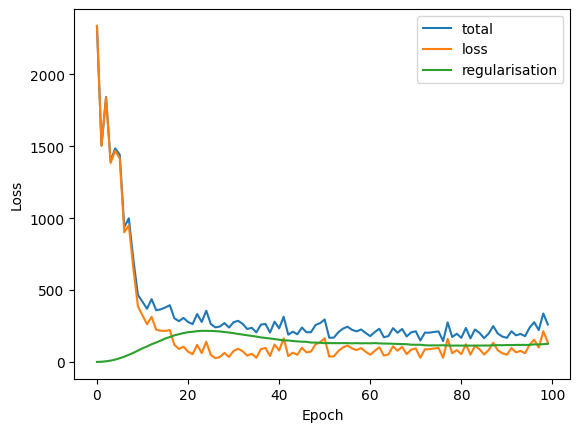

In [8]:
# we can now inspect the loss
loss_df = pd.DataFrame(vi.losses_hist)
loss_df.plot(xlabel='Epoch', ylabel='Loss');

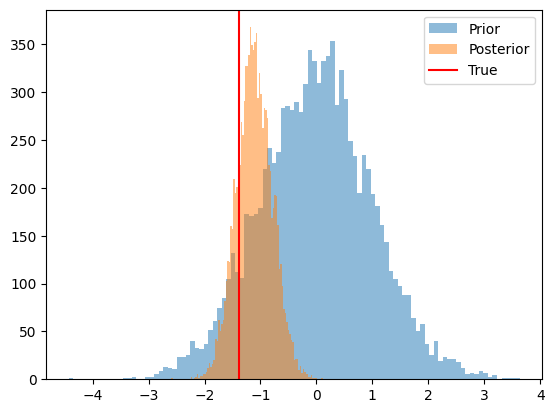

In [9]:
# and we can check the trained posterior

n_samples = 10_000
prior_samples = prior.sample((n_samples,)).numpy()
posterior_samples = q.sample(n_samples)[0].detach().numpy()

fig, ax = plt.subplots()
ax.hist(prior_samples, bins=100, alpha=0.5, label='Prior')
ax.hist(posterior_samples, bins=100, alpha=0.5, label='Posterior')
ax.axvline(theta_true.numpy(), color='red', label='True')
ax.legend();